In [1]:
import random
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

/Users/danieloliveira/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def convert_to_networkx(graph, n_sample=None):
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()
    
    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]
    
    return g, y
    
def plot_graph(g, y):
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]

g, y = convert_to_networkx(graph, n_sample=1000)

/var/folders/y5/gwwq15s92v97s_yvjxy3cqn40000gn/T/ipykernel_55420/471265407.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


In [4]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### 1) Dataset description

The Core dataset consists of 2708 scientific publications, where each node in the graph represents a paper and each edge represents a citation.

The node features "x" is an array where each row represents a node (article) and each columns is a different word in node (article). There are 2708 articles and 1433 different words in the articles. The matrix "x" is usually called the adjacency matrix.

In [6]:
graph.x.shape

torch.Size([2708, 1433])

The features are 1433 word vectors indicating the absence (0) or the presence (1) of the word in the publication:

In [7]:
print("X: ", graph.x)

X:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


The other useful information is the "edge_index" object. Each column of the array represents a node in the graph and the existence of the row represent a link between the nodes:

In [8]:
graph.edge_index.T

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

Each node has one of seven classes which is going to be our model target/label. The classes are as follows:

> 0: Theory \
> 1: Reinforcement_Learning \
> 2: Genetic_Algorithms \
> 3: Neural_Networks \
> 4: Probabilistic_Methods \
> 5: Case_Based \
> 6: Rule_Learning

In [10]:
print("y: ", graph.y)

y:  tensor([3, 4, 4,  ..., 3, 3, 3])


In [11]:
print("y classes: ", graph.y.unique())

y classes:  tensor([0, 1, 2, 3, 4, 5, 6])


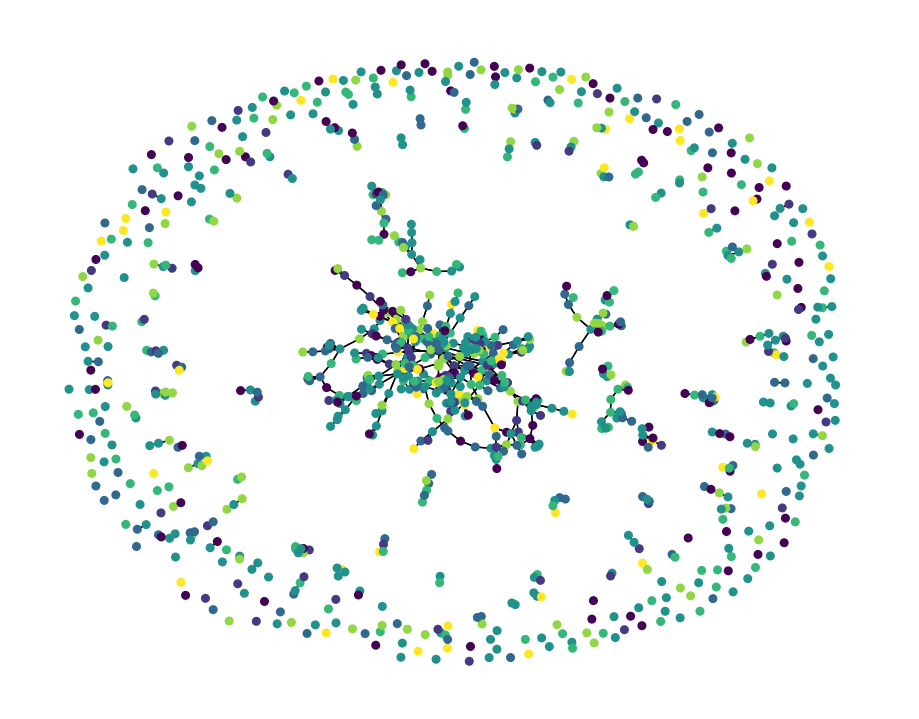

In [12]:
plot_graph(g, y)

In [5]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)

train_data, val_data, test_data = split(graph)

In [7]:
graph.edge_index.shape

torch.Size([2, 10556])

In [6]:
graph.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [13]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [9]:
train_data.edge_index

tensor([[ 458,  931, 2440,  ..., 1219, 1024, 2275],
        [1276, 1433, 2530,  ...,   45,  625, 1128]])

In [11]:
train_data.edge_index.shape

torch.Size([2, 8976])

### 1) Node classification task


Given the Cora dataset, the goal is to build a classification model for the scientific papers classes. More specifically, the model will take the frequency of the words in each article as inputs and the article classes as output.

In [16]:
print("y: ", graph.y.unique())

y:  tensor([0, 1, 2, 3, 4, 5, 6])


In [17]:
print("y classes: ", graph.y.unique())

y classes:  tensor([0, 1, 2, 3, 4, 5, 6])


In [18]:
graph.x.shape

torch.Size([2708, 1433])

In [19]:
print("X: ", graph.x)

X:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [20]:
import torch.nn as nn
import torch

In [21]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dataset.num_node_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x
        output = self.layers(x)
        
        return output

In [22]:
def eval_node_classifier(model, graph, mask):
	
	model.eval()
	pred = model(graph).argmax(dim=1)
	correct = (pred[mask] == graph.y[mask]).sum()
	acc = int(correct) / int(mask.sum())
	
	return acc

def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):
	
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 50 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model

In [23]:
device = "cpu"

mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=500)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 050, Train Loss: 0.000, Val Acc: 0.482
Epoch: 100, Train Loss: 0.002, Val Acc: 0.536
Epoch: 150, Train Loss: 0.002, Val Acc: 0.520
Epoch: 200, Train Loss: 0.002, Val Acc: 0.520
Epoch: 250, Train Loss: 0.002, Val Acc: 0.516
Epoch: 300, Train Loss: 0.002, Val Acc: 0.520
Epoch: 350, Train Loss: 0.002, Val Acc: 0.530
Epoch: 400, Train Loss: 0.002, Val Acc: 0.540
Epoch: 450, Train Loss: 0.002, Val Acc: 0.532
Epoch: 500, Train Loss: 0.002, Val Acc: 0.532
Test Acc: 0.570


In [24]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [25]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
    
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 050, Train Loss: 0.014, Val Acc: 0.766
Epoch: 100, Train Loss: 0.016, Val Acc: 0.764
Epoch: 150, Train Loss: 0.013, Val Acc: 0.770
Epoch: 200, Train Loss: 0.011, Val Acc: 0.772
Test Acc: 0.801


### 2) Link (edge) prediction task


Given the Cora dataset, the goal is to build a prediction model for the scientific papers citations (links). More specifically, the model will take the frequency of the words in each article as inputs and the link between articles as outputs.

In [26]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

In [27]:
graph.num_node_features

1433

In [37]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)

train_data, val_data, test_data = split(graph)

In [38]:
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [39]:
train_data.edge_index

tensor([[ 238, 1451,  290,  ..., 2346, 1296, 1845],
        [1828, 2564,  328,  ..., 1692,   35,  894]])

In [40]:
train_data.edge_index.shape

torch.Size([2, 8976])

In [41]:
train_data.edge_label_index

tensor([[ 238, 1451,  290,  ..., 1692,   35,  894],
        [1828, 2564,  328,  ..., 2346, 1296, 1845]])

In [42]:
train_data.edge_label_index.shape

torch.Size([2, 4488])

In [35]:
train_data.edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])

From the pyG documentation, graph links are represented in coordinate format (COO format). The COO format 

In [56]:
print("y (article citations):", train_data.edge_index)

y (article citations): tensor([[ 703,  451,  710,  ..., 2286, 1821, 2089],
        [1961,  935, 2212,  ..., 1549,  598,  306]])


In [65]:
# print("y (article groups):", train_data.y)

In [58]:
print("X (article word info): ", train_data.x)

X (article word info):  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [63]:
train_data.x.shape

torch.Size([2708, 1433])

In [66]:
dataset.num_features

1433

In [78]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(x=data.x, edge_index=data.edge_index)
    out = model.decode(z=z, edge_label_index=data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

# def train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=100):

#     for epoch in range(1, n_epochs + 1):

#         model.train()
#         optimizer.zero_grad()
#         z = model.encode(x=train_data.x, edge_index=train_data.edge_index)

#         # sampling training negatives for every training epoch
#         neg_edge_index = negative_sampling(edge_index=train_data.edge_index,
#                                            num_nodes=train_data.num_nodes,
#                                            num_neg_samples=train_data.edge_label_index.size(1), 
#                                            method='sparse')

#         edge_label_index = torch.cat(
#             [train_data.edge_label_index, neg_edge_index],
#             dim=-1,
#         )
#         edge_label = torch.cat([
#             train_data.edge_label,
#             train_data.edge_label.new_zeros(neg_edge_index.size(1))
#         ], dim=0)

#         out = model.decode(z, edge_label_index).view(-1)
#         loss = criterion(out, edge_label)
#         loss.backward()
#         optimizer.step()

#         val_auc = eval_link_predictor(model, val_data)

#         if epoch % 10 == 0:
#             print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

#     return model

In [79]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
n_epochs = 100
# model = train_link_predictor(model=model,
#                              train_data=train_data,
#                              val_data=val_data,
#                              optimizer=optimizer,
#                              criterion=criterion)

# test_auc = eval_link_predictor(model, test_data)
# print(f"Test: {test_auc:.3f}")

In [80]:
for epoch in range(1, n_epochs + 1):

    model.train()
    optimizer.zero_grad()
    z = model.encode(x=train_data.x, edge_index=train_data.edge_index)

    # sampling training negatives for every training epoch
    neg_edge_index = negative_sampling(edge_index=train_data.edge_index,
                                        num_nodes=train_data.num_nodes,
                                        num_neg_samples=train_data.edge_label_index.size(1), 
                                        method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    val_auc = eval_link_predictor(model, val_data)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")


Epoch: 010, Train Loss: 0.667, Val AUC: 0.707
Epoch: 020, Train Loss: 0.584, Val AUC: 0.823
Epoch: 030, Train Loss: 0.492, Val AUC: 0.865
Epoch: 040, Train Loss: 0.463, Val AUC: 0.885
Epoch: 050, Train Loss: 0.444, Val AUC: 0.895
Epoch: 060, Train Loss: 0.432, Val AUC: 0.905
Epoch: 070, Train Loss: 0.430, Val AUC: 0.914
Epoch: 080, Train Loss: 0.413, Val AUC: 0.913
Epoch: 090, Train Loss: 0.414, Val AUC: 0.910
Epoch: 100, Train Loss: 0.416, Val AUC: 0.908


In [82]:
train_data.edge_index

tensor([[ 703,  451,  710,  ..., 2286, 1821, 2089],
        [1961,  935, 2212,  ..., 1549,  598,  306]])

In [83]:
train_data.edge_label_index

tensor([[ 703,  451,  710,  ..., 1549,  598,  306],
        [1961,  935, 2212,  ..., 2286, 1821, 2089]])

In [87]:
train_data.edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.])